<a href="https://colab.research.google.com/github/Bouchras/TADI/blob/master/tpmorpho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#%% SECTION 1 inclusion de packages externes 
import numpy as np
import platform
import tempfile
import os
from PIL import Image  
import PIL  
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
import matplotlib.cm as cm

# POUR LA MORPHO
import skimage.morphology as morpho  
import skimage.feature as skf
from scipy import ndimage as ndi


Sources Hugues Talbot : De nombreux opérateurs morphologiques préservent la structure d’ordre, c’est-à-dire que ce sont des opérateurs croissants (x ≤ y ⇒ Φ(x) ≤ Φ(y)).  Les opérateurs les plus simples que l’on peut introduire sur un treillis sont ceux qui commutent avec le supremum ou avec l’infimum. Plus précisément, une dilatation est un opérateur croissant anti-extensif (γ(X) ≤ X) qui commute avec le supremum ∨, une érosion est un opérateur croissant extensif (γ(X) ≥ X) qui commute avec l’infimum ∧. Ces deux opérateurs sont duaux l’un par rapport à l’autre.
Dans une image binaire, la structure d’ordre ≤ est donné par l’inclusion ⊆, le supremum ∨ par l’union ∪, et l’infimum ∧ par l’intersection ∩


In [0]:

#%% SECTION 2 fonctions utiles pour le TP

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase= ' '
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase=' &'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)


def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

            

def couleurs_alea(im):
    """ 
    Donne des couleurs aleatoires a une image en niveau de gris.
    Cette fonction est utile lorsque le niveua de gris d'interprete comme un numero
      de region. Ou encore pour voir les leger degrades d'une teinte de gris.
      """
    sh=im.shape
    out=np.zeros((sh,3),dtype=np.uint8)
    nbcoul=np.int32(im.max())
    tabcoul=np.random.randint(0,256,size=(nbcoul+1,3))
    tabcoul[0,:]=0
    for k in range(sh[0]):
        for l in range(sh[1]):
            out[k,l,:]=tabcoul[im[k,l]]
    return out

# SECTION 3 exemples de commandes pour effectuer ce qui est demande pendant le TP


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


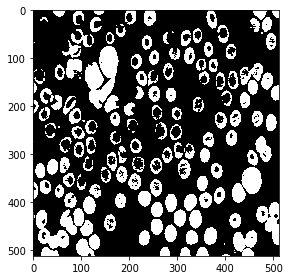

In [0]:
im=skio.imread('cellbin.bmp') #affichage de l'image d'origine
viewimage(im)
skio.imshow(im)

In [0]:
se=strel('disk',4)

## 1 Dilatation 

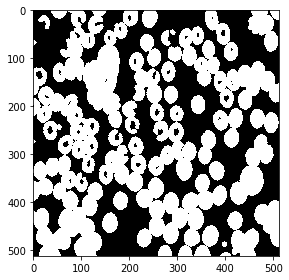

In [0]:
dil4=morpho.dilation(im,se)
#viewimage(dil4)
skio.imshow(dil4)


En considérant un élément structurant B et une image X : la dilatation de X est le résultat de l’intersection de B avec X, par conséquent la dilattion de X par B grossit.
- La dilatation d'un petit objet est plus petite que celle d'un objet plus grand( croissance)
- Les objets de départ sont inclus dans leur dilaté ( extensivité)

#### 1.1 Modifier la taille de l'element structurant

In [0]:
seG=strel('line',20)
dil5 = morpho.dilation(im,seG)
#viewimage(dil5)
skio.imshow(dil5)

##### Observations : 
Faire croitre la taille de l'element structurant : 
- Toutes les cellules grossisent.
- S'il existe des trous (qui est le fond de l'image) dans les cellules, ils sont comblés.
- Les cellules qui sont situées l'une de l'autre à une distance plus petite que la taille de l'element structurant, sont fusionnées. 

#### 1.2 Modifier la forme de l'element structurant


In [0]:
se1=strel('line',10)
dilLine = morpho.dilation(im,se1)
#viewimage(dilLine)
skio.imshow(dilLine)

- Le résultat de la dilatation varie selon l'element structurant.
 - Si B est un carré alors les bords ont une forme d'escaliers.
 - Si B est un disk : le bord des objets est lisse.
 - Si B est une ligne : 

#### 1.3 Verification de l'idempotence

In [0]:
se1=strel('disk',5)
dilDisk1= morpho.dilation(im,se1)
#viewimage(dilDisk1)
skio.imshow(dilDisk1)

In [0]:
se2=strel('disk',5)
dilDisk2 = morpho.dilation(dilDisk1,se2)
#viewimage(dilDisk2)
skio.imshow(dilDisk2)


In [0]:
se3=strel('disk',5)
dilDisk3 = morpho.dilation(dilDisk2,se3)
#viewimage(dilDisk3)
skio.imshow(dilDisk3)

#### 1.4 Conclusion sur la dilatation : 

## 2 Erosion 

In [0]:
ero4=morpho.erosion(im,se)
viewimage(ero4)
skio.imshow(ero4)

En considérant un élément structurant B et une image X : l'érosion de X est le résultat quand B est completement inclus dans X par conséquant l'érosion réduit la taille des objets présents dans l'image.
- les objets de taille inferieure à celle de B disparaissent.
    

#### 2.1 Modifier la taille de l'element structurant

In [0]:
seG=strel('disk',10)
ero5=morpho.erosion(im,seG)
viewimage(ero5)
skio.imshow(ero5)

- En augmentant la taille de B, les objets rétrecissent et ceux de tailles inferieurs à celle de B dispraraissent.
- Les trous (le fond) dans les objets s'accentuent.
- Les objets reliés entre eux sont séparés.

#### 2.2 Modifier la forme de l'element structurant


In [0]:
seL=strel('line',5)
eroL=morpho.erosion(im,seL)
#viewimage(eroL)
skio.imshow(eroL)

In [0]:
seD=strel('diamond',5)
eroD=morpho.erosion(im,seD)
#viewimage(eroD)
skio.imshow(eroD)

####  2.3 Verification de l'idempotence

In [0]:
eroD1= morpho.erosion(im,se1)
skio.imshow(eroD1)

In [0]:
eroD2 = morpho.erosion(eroD1,se2)
skio.imshow(eroD2)

#### 2.4 Conclusion sur l'érosion: 

- L'érosion est une transformation croissante.
- L'érosion est antiextensive.
- L'érosion  n'est pas idempotente. 
- L'érosion  rétrécie les objets présents dans l’image et la direction et la taille de ce rétrécissement dépendent de la forme et la taille de l’élément structurant.

____
- L'érosion et la dilatation sont des opérations duales mais pas inverses et non reversibles. 
- La dilatation fait disparaître les petits trous et fais grossir les objets
- L'érosion fait disparaître les petits objets et les petits isthmes et amincie le reste des objets.
___

## 3 Ouverture

- L'ouverture est une érosion par B suivie d'une dilatation avec le même element structurant.

In [0]:
skio.imshow(im)

In [0]:
#Disk
se = strel('disk',4)
open4=morpho.opening(im,se)
#viewimage(open4)
skio.imshow(open4)


#### 3.1 Modifier la forme de l'element structurant

In [0]:
# Line
seL = strel('line',4)
open4L=morpho.opening(im,seL)
#viewimage(open4L)
skio.imshow(open4L)

### 3.2 Modifier la taille de l'element structurant

In [0]:
# Disk = 10
open10G=morpho.opening(im,seG)
#viewimage(open10)
skio.imshow(open10G)

In [0]:
# Diamond = 10
seD = strel('diamond', 10)
open10D=morpho.opening(im,seD)
#viewimage(open10D)
skio.imshow(open10D)

### 3.3 Idempotence

In [0]:
open42=morpho.opening(open4,se)
#viewimage(open4)
skio.imshow(open42)

plt.subplot(131)
plt.imshow(im, norm = None)

plt.subplot(132)
plt.imshow(open4, norm = None)

plt.subplot(133)
plt.imshow(open42, norm = None)


## 4 Fermeture

In [0]:
#fermeture
close4=morpho.closing(im,se)
viewimage(close4)
skio.imshow(close4)

_______________
- L'ouverture élimine les objets qui sont plus petits que B et déforme les coins convexes. 
- La fermeture rebouche toutes les parties du fond, qui sont plus petites que B et déforme les coins concaves de l'image.
________________

successiond'unedilatationparuncarrédetaille3×3etd'unedilatationparuncarrédetaille5×5